<a href="https://colab.research.google.com/github/trhieu2/hands-on-ml-practices/blob/main/end_to_end_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get data

In [1]:
from pathlib import Path
import tarfile
import urllib.request
import pandas as pd

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url="https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
  with tarfile.open(tarball_path) as housing_price:
    housing_price.extractall(path="datasets")
  return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

/tmp/ipython-input-839821780.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_price.extractall(path="datasets")


# Take a look at the data


In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing['ocean_proximity'].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


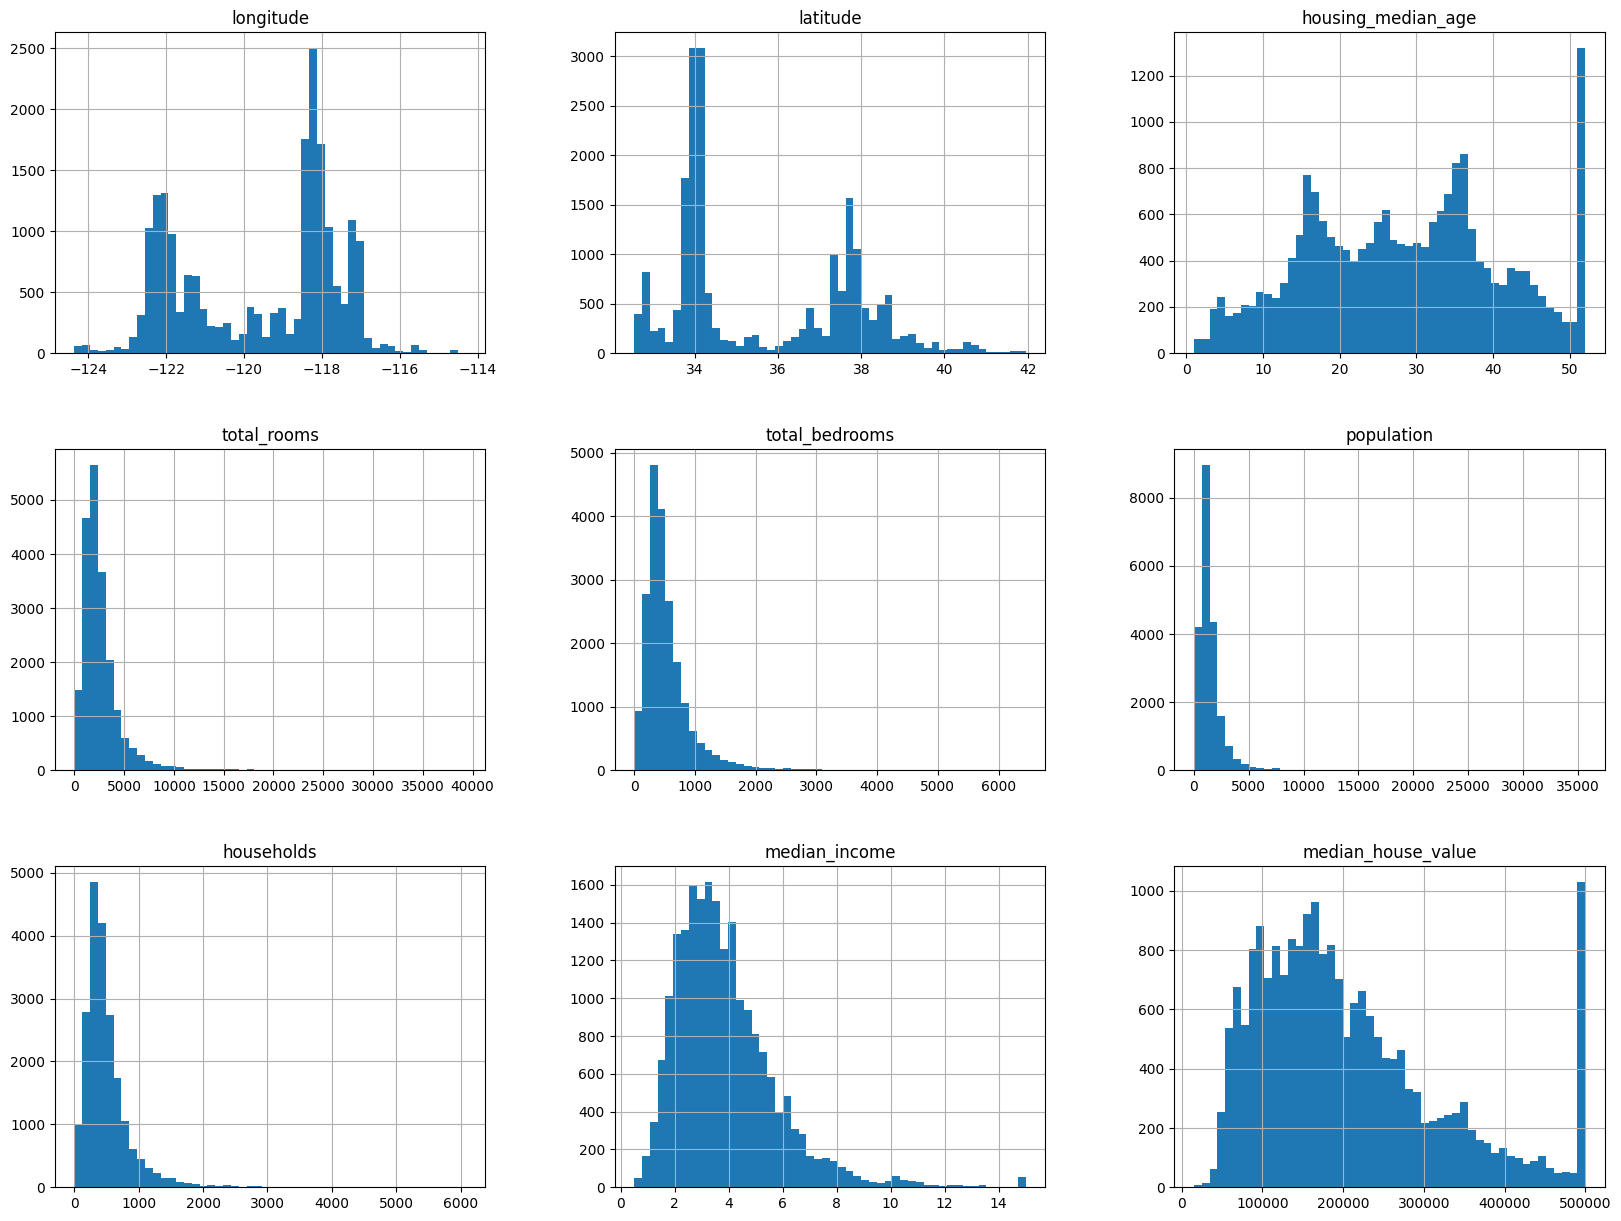

In [6]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show()

# Create a Test Set

In [9]:
#manually creating a test set and training set
import numpy as np

def shuffle_and_split_data(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_size]
  train_indices = shuffled_indices[test_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [12]:
len(train_set), len(test_set)

(16512, 4128)

In [13]:
np.random.seed(42)

In [14]:
#using scikit-learn lib
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
test_set['total_bedrooms'].isnull().sum()

np.int64(44)

In [16]:
#The median income is a critical attribute, so it should be representative of the whole dataset
#First transform it into a categorical attribute
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1,2,3,4,5])

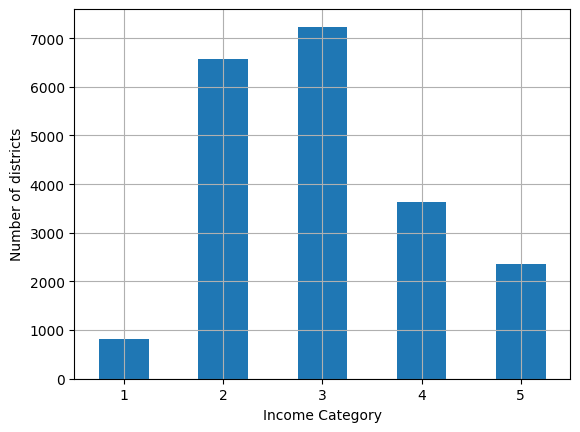

In [18]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Income Category')
plt.ylabel('Number of districts')
plt.show()

In [19]:
#Applying stratified sampling
#The split function return the indices of train and test sets to be exact
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing['income_cat']):
  strat_train = housing.iloc[train_index]
  strat_test = housing.iloc[test_index]
  strat_splits.append((strat_train, strat_test))

In [20]:
strat_train_set, strat_test_set = strat_splits[0]

In [21]:
#Shorter way to get a single split using the train_set_split()
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'], random_state=42)

In [22]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

,count
income_cat,
3,0.350594
2,0.318859
4,0.176296
5,0.114462
1,0.039789


In [23]:
#Just use income_cat for the sake of set-splitting, now we can get rid of it
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [24]:
housing = strat_train_set.copy()

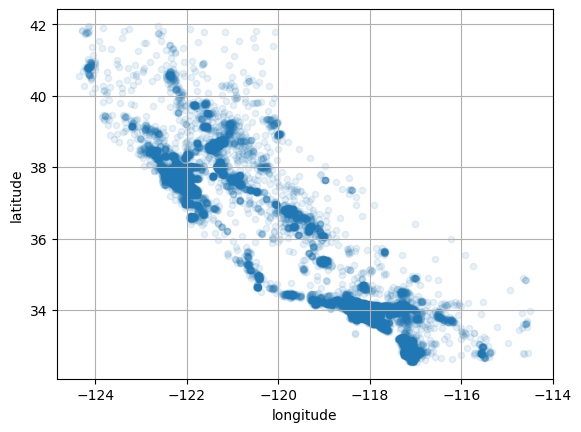

In [29]:
#Cause the dataset includes a geographical attribute -> It's good to use sccatterplot
housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.1, grid=True)
plt.show()

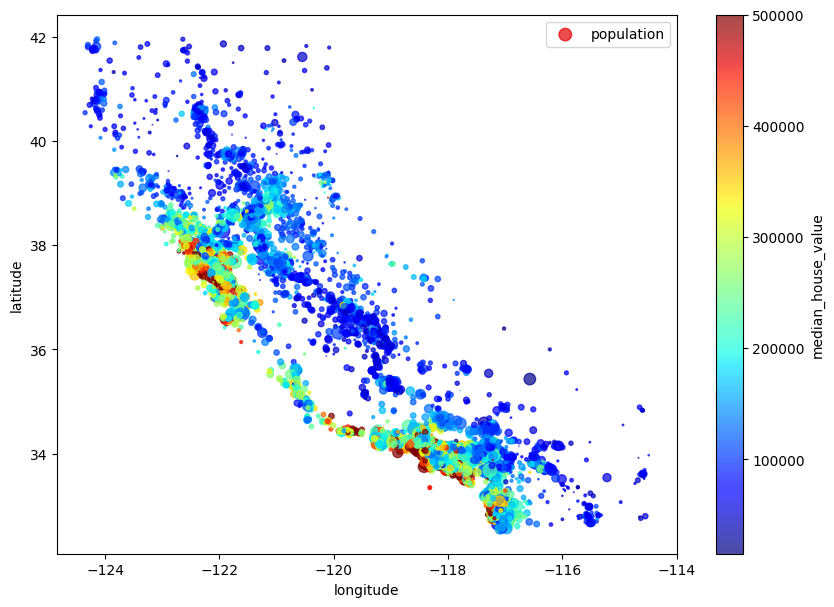

In [32]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.7, s=housing['population']/100, label ="population", c="median_house_value", cmap='jet', colorbar=True, legend=True, sharex=False, figsize=(10,7))
plt.show()

The housing prices are very much related to the location, and the population density

# Looking for Correlation